In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

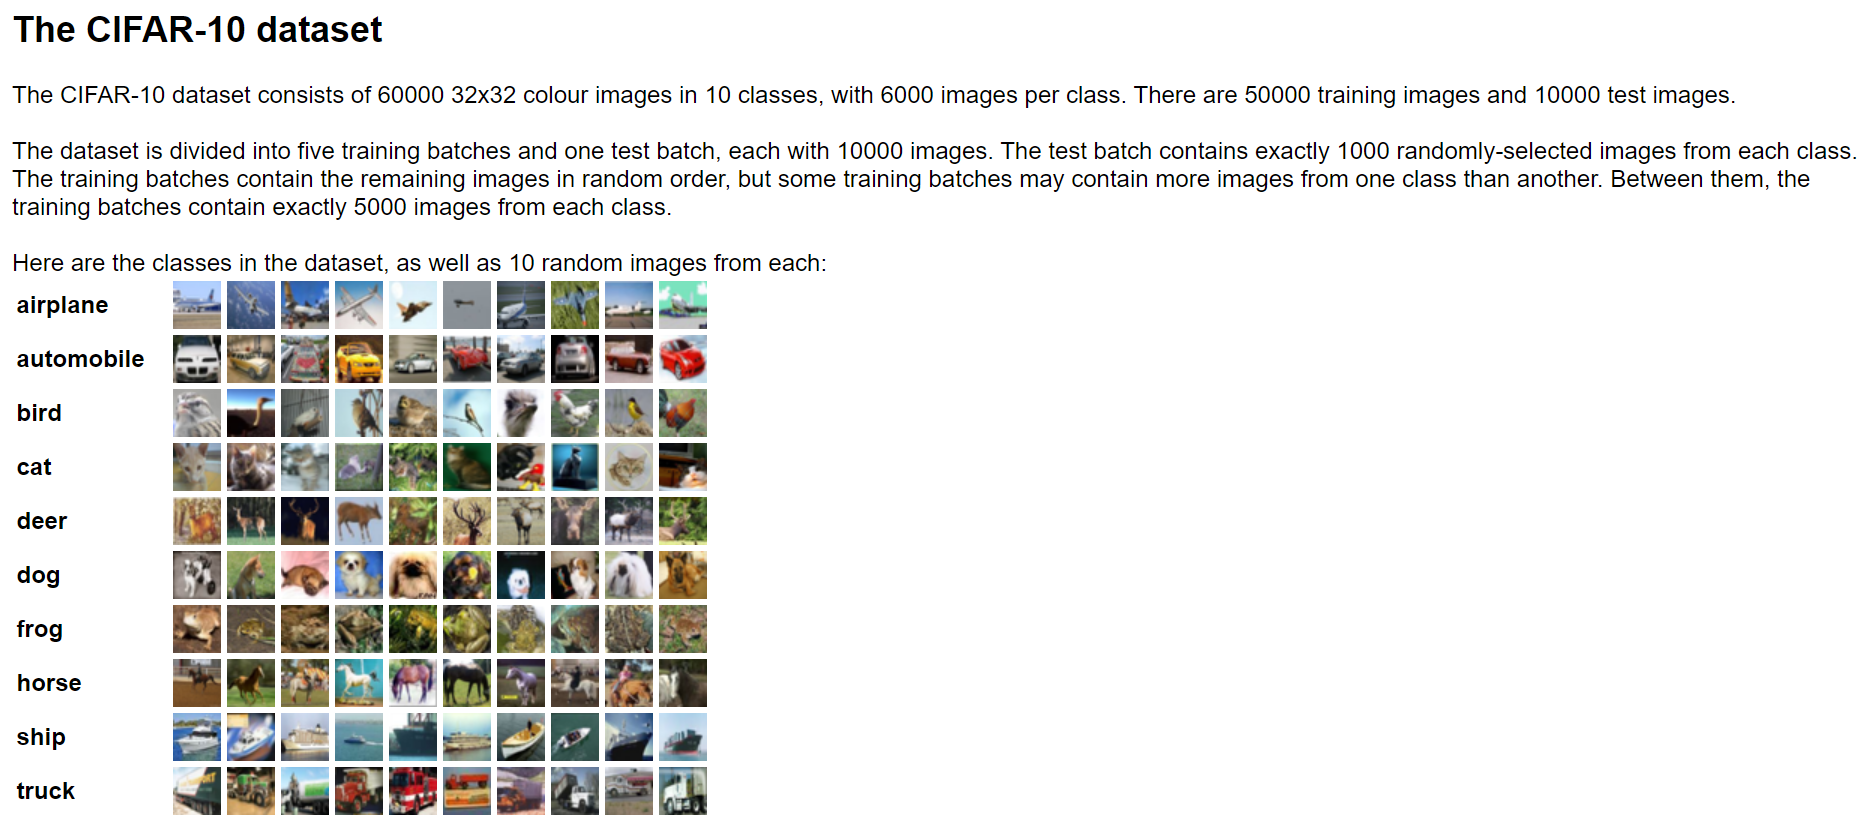

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 25
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


#Resnet Model

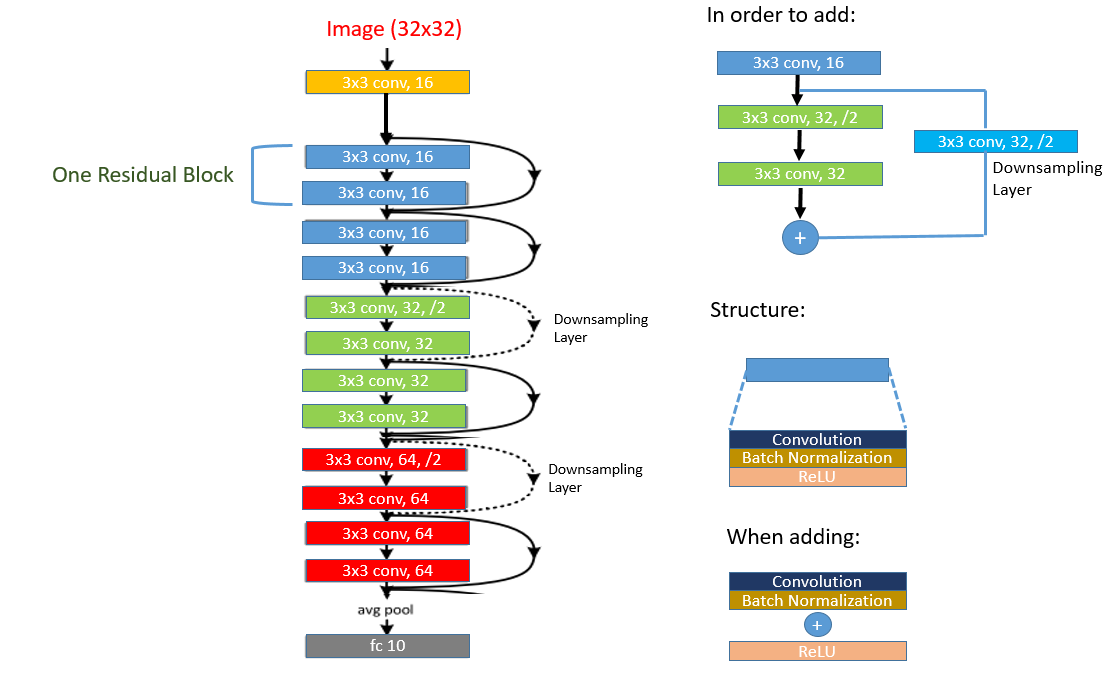

In [3]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Train

In [6]:
decay = 0
model.train()
for epoch in range(num_epochs):
    
    # Decay the learning rate every 20 epochs
    if (epoch+1) % 20 == 0:
        decay+=1
        optimizer.param_groups[0]['lr'] = learning_rate * (0.5**decay)
        print("The new learning rate is {}".format(optimizer.param_groups[0]['lr']))
        
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/25], Step [100/500] Loss: 1.4991
Epoch [1/25], Step [200/500] Loss: 1.4255
Epoch [1/25], Step [300/500] Loss: 1.4116
Epoch [1/25], Step [400/500] Loss: 1.1096
Epoch [1/25], Step [500/500] Loss: 1.2042
Epoch [2/25], Step [100/500] Loss: 1.1077
Epoch [2/25], Step [200/500] Loss: 1.0598
Epoch [2/25], Step [300/500] Loss: 0.8563
Epoch [2/25], Step [400/500] Loss: 1.1107
Epoch [2/25], Step [500/500] Loss: 0.9687
Epoch [3/25], Step [100/500] Loss: 0.9153
Epoch [3/25], Step [200/500] Loss: 0.8582
Epoch [3/25], Step [300/500] Loss: 0.8298
Epoch [3/25], Step [400/500] Loss: 0.7148
Epoch [3/25], Step [500/500] Loss: 0.7962
Epoch [4/25], Step [100/500] Loss: 0.7368
Epoch [4/25], Step [200/500] Loss: 0.9931
Epoch [4/25], Step [300/500] Loss: 0.8636
Epoch [4/25], Step [400/500] Loss: 0.7879
Epoch [4/25], Step [500/500] Loss: 0.6013
Epoch [5/25], Step [100/500] Loss: 0.7189
Epoch [5/25], Step [200/500] Loss: 0.6121
Epoch [5/25], Step [300/500] Loss: 0.6574
Epoch [5/25], Step [400/500] Loss:

#Test

In [7]:
#Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 85.77 %
